In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

In [2]:
#pip install plotly==4.4.

recovered_global_df = pd.read_csv('time_series_covid19_recovered_global.csv' )
confirmed_global_df = pd.read_csv('time_series_covid19_confirmed_global.csv' )
deaths_global_df = pd.read_csv('time_series_covid19_deaths_global.csv')

recovered_global_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,31234,31638,32073,32098,32503,32505,32576,32576,32576,32576
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,6494,6569,6615,6668,6733,6788,6831,6888,6940,6995
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,33875,34037,34204,34385,34517,34675,34818,34923,35047,35180
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,943,943,945,945,1054,1054,1164,1164,1164,1199
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,1289,1301,1324,1332,1401,1405,1443,1445,1445,1449


In [3]:
from datetime import datetime

def _convert_date_str(df):
        df.columns = list(df.columns[:4]) + [pd.to_datetime(d, infer_datetime_format=True) for d in df.columns[4:]]
    

recovered_global_df = pd.read_csv('time_series_covid19_recovered_global.csv' )
confirmed_global_df = pd.read_csv('time_series_covid19_confirmed_global.csv' )
deaths_global_df = pd.read_csv('time_series_covid19_deaths_global.csv')


_convert_date_str(confirmed_global_df)
_convert_date_str(deaths_global_df)
_convert_date_str(recovered_global_df)

In [4]:
recovered_global_df.head()

,Province/State,Country/Region,Lat,Long,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,...,2020-09-12 00:00:00,2020-09-13 00:00:00,2020-09-14 00:00:00,2020-09-15 00:00:00,2020-09-16 00:00:00,2020-09-17 00:00:00,2020-09-18 00:00:00,2020-09-19 00:00:00,2020-09-20 00:00:00,2020-09-21 00:00:00
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,31234,31638,32073,32098,32503,32505,32576,32576,32576,32576
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,6494,6569,6615,6668,6733,6788,6831,6888,6940,6995
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,33875,34037,34204,34385,34517,34675,34818,34923,35047,35180
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,943,943,945,945,1054,1054,1164,1164,1164,1199
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,1289,1301,1324,1332,1401,1405,1443,1445,1445,1449


In [5]:
# Filter out problematic data points (The West Bank and Gaza had a negative value, cruise ships were associated with Canada, etc.)
removed_states = "Recovered|Grand Princess|Diamond Princess"
removed_countries = "The West Bank and Gaza"

confirmed_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)
deaths_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)
recovered_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)

confirmed_global_df = confirmed_global_df[~confirmed_global_df["Province_State"].replace(np.nan, "nan").str.match(removed_states)]
deaths_global_df    = deaths_global_df[~deaths_global_df["Province_State"].replace(np.nan, "nan").str.match(removed_states)]
recovered_global_df = recovered_global_df[~recovered_global_df["Province_State"].replace(np.nan, "nan").str.match(removed_states)]

confirmed_global_df = confirmed_global_df[~confirmed_global_df["Country_Region"].replace(np.nan, "nan").str.match(removed_countries)]
deaths_global_df    = deaths_global_df[~deaths_global_df["Country_Region"].replace(np.nan, "nan").str.match(removed_countries)]
recovered_global_df = recovered_global_df[~recovered_global_df["Country_Region"].replace(np.nan, "nan").str.match(removed_countries)]

confirmed_global_df


,Province_State,Country_Region,Lat,Long,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,...,2020-09-12 00:00:00,2020-09-13 00:00:00,2020-09-14 00:00:00,2020-09-15 00:00:00,2020-09-16 00:00:00,2020-09-17 00:00:00,2020-09-18 00:00:00,2020-09-19 00:00:00,2020-09-20 00:00:00,2020-09-21 00:00:00
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,38641,38716,38772,38815,38855,38872,38883,38919,39044,39074
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,11185,11353,11520,11672,11816,11948,12073,12226,12385,12535
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,48007,48254,48496,48734,48966,49194,49413,49623,49826,50023
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,1344,1344,1438,1438,1483,1483,1564,1564,1564,1681
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,3335,3388,3439,3569,3675,3789,3848,3901,3991,4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,29906,30574,31362,32250,33006,33843,34401,35003,35686,36151
262,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2009,2011,2013,2016,2019,2022,2024,2026,2026,2028
264,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,13466,13539,13720,13819,13887,13928,14022,14070,14131,14175


In [6]:
confirmed_global_df.shape

(264, 248)

In [7]:
confirmed_global_melt_df = confirmed_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='ConfirmedCases')
deaths_global_melt_df = deaths_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=deaths_global_df.columns[4:], var_name='Date', value_name='Deaths')
recovered_global_melt_df = deaths_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=recovered_global_df.columns[4:], var_name='Date', value_name='Recovered')

confirmed_global_melt_df.tail()

,Country_Region,Province_State,Lat,Long,Date,ConfirmedCases
64411,West Bank and Gaza,NaN,31.952200,35.233200,2020-09-21,36151
64412,Western Sahara,NaN,24.215500,-12.885800,2020-09-21,10
64413,Yemen,NaN,15.552727,48.516388,2020-09-21,2028
64414,Zambia,NaN,-13.133897,27.849332,2020-09-21,14175
64415,Zimbabwe,NaN,-19.015438,29.154857,2020-09-21,7683


In [8]:
confirmed_global_melt_df.shape

(64416, 6)

In [9]:
train = confirmed_global_melt_df.merge(deaths_global_melt_df, on=['Country_Region', 'Province_State', 'Lat', 'Long', 'Date'])
train = train.merge(recovered_global_melt_df, on=['Country_Region', 'Province_State', 'Lat', 'Long', 'Date'])

In [10]:
train


,Country_Region,Province_State,Lat,Long,Date,ConfirmedCases,Deaths,Recovered
0,Afghanistan,NaN,33.939110,67.709953,2020-01-22,0,0,0
1,Albania,NaN,41.153300,20.168300,2020-01-22,0,0,0
2,Algeria,NaN,28.033900,1.659600,2020-01-22,0,0,0
3,Andorra,NaN,42.506300,1.521800,2020-01-22,0,0,0
4,Angola,NaN,-11.202700,17.873900,2020-01-22,0,0,0
...,...,...,...,...,...,...,...,...
58555,Venezuela,NaN,6.423800,-66.589700,2020-09-21,67443,555,555
58556,West Bank and Gaza,NaN,31.952200,35.233200,2020-09-21,36151,265,265
58557,Western Sahara,NaN,24.215500,-12.885800,2020-09-21,10,1,1
58558,Zambia,NaN,-13.133897,27.849332,2020-09-21,14175,331,331


In [11]:
df =train

In [12]:
def pltCountry_cases(ConfirmedCases,*argv):
    f, ax=plt.subplots(figsize=(16,5))
    labels=argv
    for a in argv: 
        country=df.loc[(df['Country_Region']==a)]
        plt.plot(country['Date'],country['ConfirmedCases'],linewidth=3)
        plt.xticks(rotation=40)
        plt.legend(labels)
        ax.set(title='Evolution of the number of cases' )
  


In [13]:
def pltCountry_fatalities(Fatalities,*argv):
    f, ax=plt.subplots(figsize=(16,5))
    labels=argv
    for a in argv: 
        country=df.loc[(df['Country_Region']==a)]
        plt.plot(country['Date'],country['Deaths'],linewidth=3)
        plt.xticks(rotation=40)
        plt.legend(labels)
        ax.set(title='Evolution of the number of fatalities' )

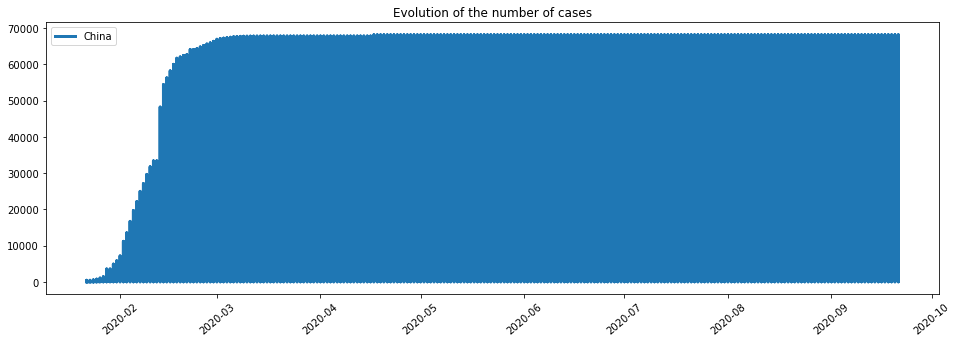

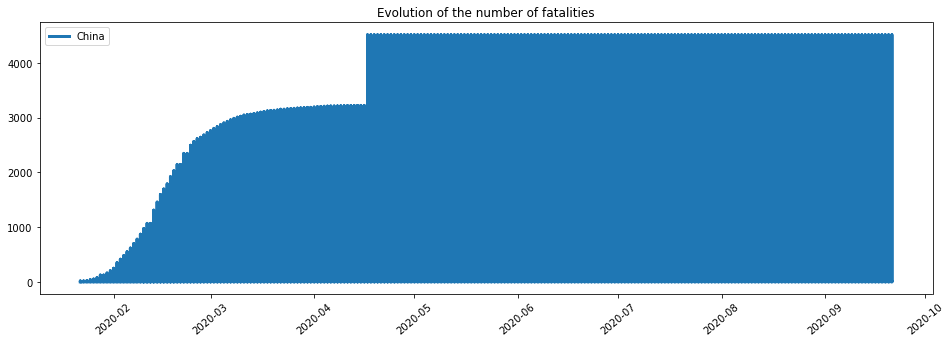

In [14]:
pltCountry_cases('ConfirmedCases','China')
pltCountry_fatalities('Deaths','China')

In [15]:
case='ConfirmedCases'
def timeCompare(time,*argv):
    Coun1=argv[0]
    Coun2=argv[1]
    f,ax=plt.subplots(figsize=(16,5))
    labels=argv  
    country=df.loc[(df['Country_Region']==Coun1)]
    plt.plot(country['Date'],country[case],linewidth=2)
    plt.xticks([])
    plt.legend(labels)
    ax.set(title=' Evolution of actual cases',ylabel='Number of cases' )

    country2=df.loc[df['Country_Region']==Coun2]
    #country2['Date']=country2['Date']-datetime.timedelta(days=time)
    plt.plot(country2['Date'],country2[case],linewidth=2)
    #plt.xticks([])
    plt.legend(labels)
    ax.set(title=' Evolution of cases in %d days difference '%time ,ylabel='Number of %s cases'%case )

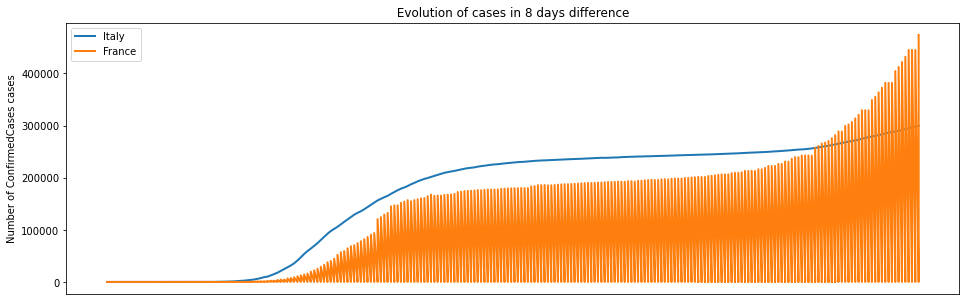

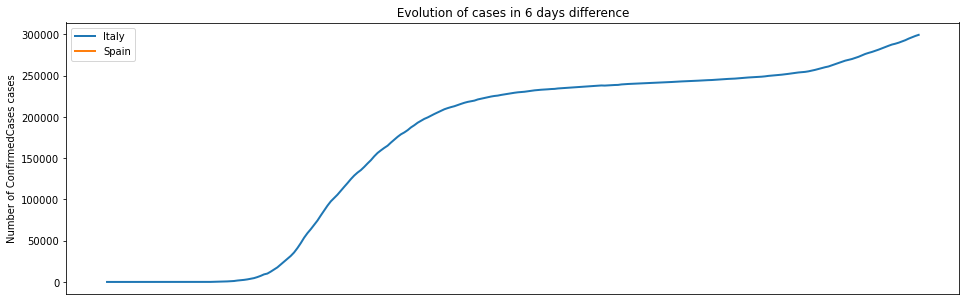

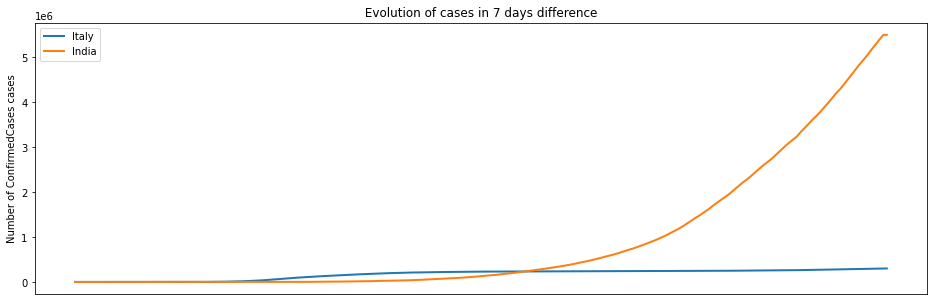

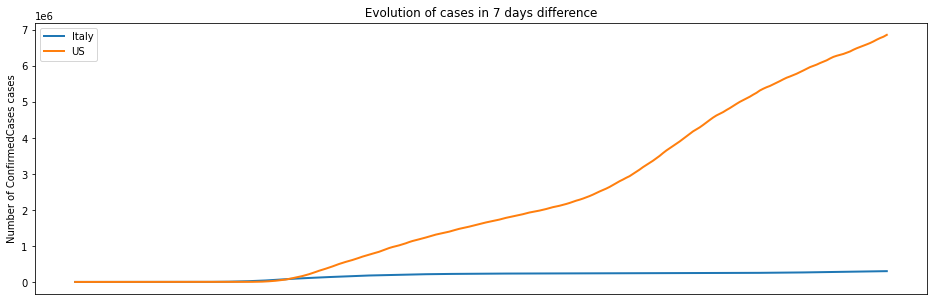

In [16]:
timeCompare(8,'Italy','France')
timeCompare(6,'Italy','Spain')
timeCompare(7,'Italy','India')
timeCompare(7,'Italy','US')

# ARIMA MODEL

In [17]:
sns.set(palette = 'Set1',style='darkgrid')
#Function for making a time serie on a designated country and plotting the rolled mean and standard 
def roll(country,case='ConfirmedCases'):
    ts=df.loc[(df['Country_Region']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['ConfirmedCases']>=10)])
    ts=ts[-a:]
    return (ts.rolling(window=4,center=False).mean().dropna())


def rollPlot(country, case='ConfirmedCases'):
    ts=df.loc[(df['Country_Region']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['ConfirmedCases']>=10)])
    ts=ts[-a:]
    plt.figure(figsize=(16,6))
    plt.plot(ts.rolling(window=7,center=False).mean().dropna(),label='Rolling Mean')
    plt.plot(ts[case])
    plt.plot(ts.rolling(window=7,center=False).std(),label='Rolling std')
    plt.legend()
    plt.title('Cases distribution in %s with rolling mean and standard' %country)
    plt.xticks([])

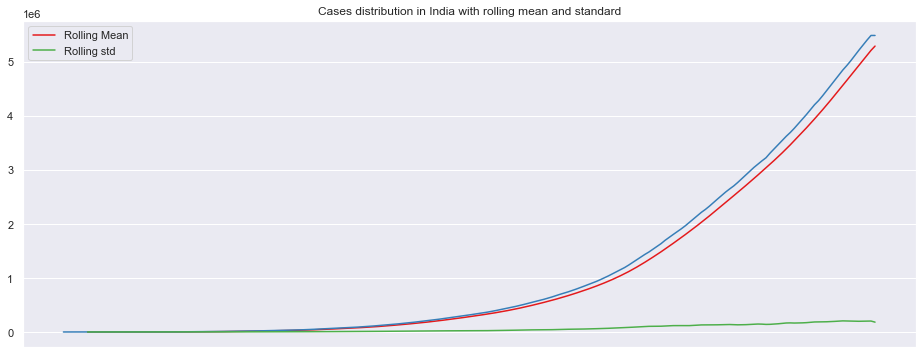

In [18]:
tsC1=roll('India')
rollPlot('India')

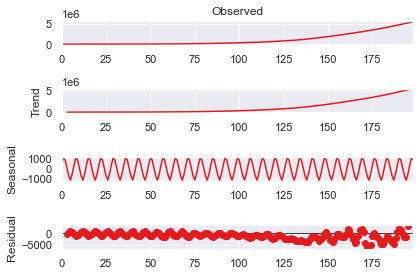

In [19]:
fig=sm.tsa.seasonal_decompose(tsC1.values,freq=7).plot()

In [20]:
df

,Country_Region,Province_State,Lat,Long,Date,ConfirmedCases,Deaths,Recovered
0,Afghanistan,NaN,33.939110,67.709953,2020-01-22,0,0,0
1,Albania,NaN,41.153300,20.168300,2020-01-22,0,0,0
2,Algeria,NaN,28.033900,1.659600,2020-01-22,0,0,0
3,Andorra,NaN,42.506300,1.521800,2020-01-22,0,0,0
4,Angola,NaN,-11.202700,17.873900,2020-01-22,0,0,0
...,...,...,...,...,...,...,...,...
58555,Venezuela,NaN,6.423800,-66.589700,2020-09-21,67443,555,555
58556,West Bank and Gaza,NaN,31.952200,35.233200,2020-09-21,36151,265,265
58557,Western Sahara,NaN,24.215500,-12.885800,2020-09-21,10,1,1
58558,Zambia,NaN,-13.133897,27.849332,2020-09-21,14175,331,331


In [21]:
X=df
train=X[:170]
test=X[170:]

In [22]:
train.head()

,Country_Region,Province_State,Lat,Long,Date,ConfirmedCases,Deaths,Recovered
0,Afghanistan,NaN,33.93911,67.709953,2020-01-22,0,0,0
1,Albania,NaN,41.15330,20.168300,2020-01-22,0,0,0
2,Algeria,NaN,28.03390,1.659600,2020-01-22,0,0,0
3,Andorra,NaN,42.50630,1.521800,2020-01-22,0,0,0
4,Angola,NaN,-11.20270,17.873900,2020-01-22,0,0,0


In [23]:
test.head()

,Country_Region,Province_State,Lat,Long,Date,ConfirmedCases,Deaths,Recovered
170,Netherlands,Curacao,12.169600,-68.990000,2020-01-22,0,0,0
171,Netherlands,Sint Maarten,18.042500,-63.054800,2020-01-22,0,0,0
172,Netherlands,NaN,52.132600,5.291300,2020-01-22,0,0,0
173,New Zealand,NaN,-40.900600,174.886000,2020-01-22,0,0,0
174,Nicaragua,NaN,12.865416,-85.207229,2020-01-22,0,0,0


In [24]:
#Function to check the stationarity of the time serie using Dickey fuller test
def stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    test = adfuller(ts, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for i,val in test[4].items():
        results['Critical Value (%s)'%i] = val
    print (results)

#For China
tsC=tsC1['ConfirmedCases'].values
stationarity(tsC)

Results of Dickey-Fuller Test:
Test Statistic                  -2.539350
p-value                          0.106191
#Lags Used                      15.000000
Number of Observations Used    183.000000
Critical Value (1%)             -3.466598
Critical Value (5%)             -2.877467
Critical Value (10%)            -2.575260
dtype: float64


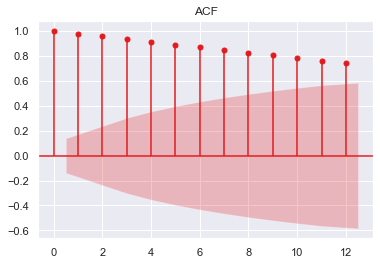

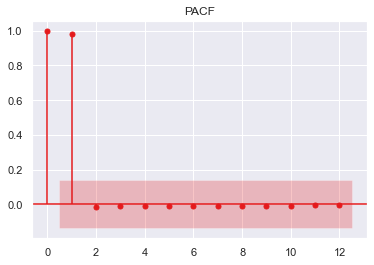

In [25]:
def corr(ts):
    plot_acf(ts,lags=12,title="ACF")
    plot_pacf(ts,lags=12,title="PACF")
    

#For China
corr(tsC1)

In [26]:
train = train.set_index(['Date'])
test = test.set_index(['Date'])

In [27]:
def create_features(df,label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['Date'] = df.index
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
   
    return X

In [28]:
train_features=pd.DataFrame(create_features(train))
test_features=pd.DataFrame(create_features(test))
features_and_target_train = pd.concat([train,train_features], axis=1)
features_and_target_test = pd.concat([test,test_features], axis=1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def FunLabelEncoder(df):
    for c in df.columns:
        if df.dtypes[c] == object:
            le.fit(df[c].astype(str))
            df[c] = le.transform(df[c].astype(str))
    return df
features_and_target_train= FunLabelEncoder(features_and_target_train)

In [29]:
x_train= features_and_target_train[['Country_Region','month', 'dayofyear', 'dayofmonth' , 'weekofyear']]
y1 = features_and_target_train[['ConfirmedCases']]
y2 =features_and_target_train[['Deaths']]
x_test = features_and_target_test[['Country_Region', 'month', 'dayofyear', 'dayofmonth' , 'weekofyear']]


                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  167
Model:                 ARIMA(4, 2, 3)   Log Likelihood               -1267.847
Method:                       css-mle   S.D. of innovations            458.863
Date:                Sat, 27 Mar 2021   AIC                           2553.695
Time:                        18:26:25   BIC                           2581.757
Sample:                             2   HQIC                          2565.084
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        408.3417     76.524      5.336      0.000     258.357     558.327
ar.L1.D2.y     0.0185      0.071      0.261      0.794      -0.120       0.157
ar.L2.D2.y    -0.3625      0.070     -5.146      0.0

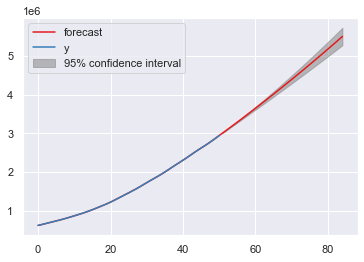

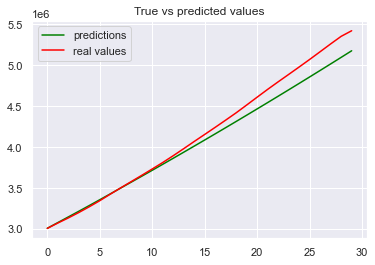

In [30]:
import itertools
#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.85)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.7), end=int(len(ts) * 1.2))
    pred=result.forecast(steps=len(test))[0]
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(pred,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('True vs predicted values')
    #Printing the error metrics
    print(result.summary())        
    
    print('\nMean absolute percentage error: %f'%mape(test,pred))
    return (pred)



train,test=split(tsC)
pred=arima(train,test)

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  167
Model:                 ARIMA(4, 2, 3)   Log Likelihood               -1267.847
Method:                       css-mle   S.D. of innovations            458.863
Date:                Sat, 27 Mar 2021   AIC                           2553.695
Time:                        18:26:42   BIC                           2581.757
Sample:                             2   HQIC                          2565.084
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        408.3417     76.524      5.336      0.000     258.357     558.327
ar.L1.D2.y     0.0185      0.071      0.261      0.794      -0.120       0.157
ar.L2.D2.y    -0.3625      0.070     -5.146      0.0

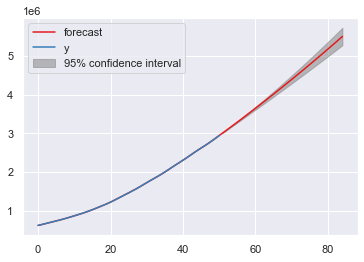

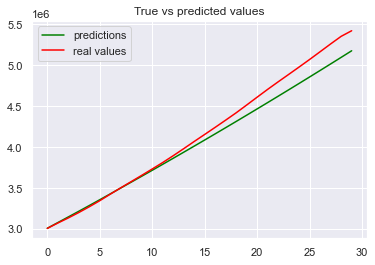

In [31]:
#Mean absolute percentage error
def mape(y2, y_pred): 
    y2, y_pred = np.array(y2), np.array(y_pred)
    return np.mean(np.abs((y2 - y_pred) / y2)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.85)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.7), end=int(len(ts) * 1.2))
    pred=result.forecast(steps=len(test))[0]
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(pred,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('True vs predicted values')
    #Printing the error metrics
    print(result.summary())        
    
    print('\nMean absolute percentage error: %f'%mape(test,pred))
    return (pred)



train,test=split(tsC)
pred=arima(train,test)